In [3]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import sqlite3

# Symbol
symbol = 'BTCUSDT'

# Start and end time stamps
start_year = 2023
start_month = 1
start_day = 1

start_datetime = datetime.datetime(start_year, start_month, start_day)
start_timestamp = time.mktime(start_datetime.timetuple()) * 1000 # In milliseconds 
start_timestamp = int(start_timestamp)

end_year = 2024
end_month = 1
end_day = 1

end_datetime = datetime.datetime(end_year, end_month, end_day)
end_timestamp = time.mktime(end_datetime.timetuple()) * 1000 # In milliseconds 
end_timestamp = int(end_timestamp)

# Get data set. First I'll pull all the data at once, then refactor for a data source object
sql_check_spec = '''SELECT ticker_time, open_price, volume FROM spot_entry WHERE symbol = ? and ticker_time > ? and ticker_time < ?'''

connection = sqlite3.connect("../database/ticker_data.db")
with connection:
    cursor = connection.cursor()

sql_check_val = (symbol,) + (start_timestamp,) + (end_timestamp,)

cursor.execute(sql_check_spec, sql_check_val)
spot_data = cursor.fetchall()
spot_data = np.array(spot_data)


Buy
1:Sell
Buy
2:Sell
Buy
3:Sell
Buy
4:Sell
Buy
5:Sell
Buy
6:Sell
Buy
7:Sell
Buy
8:Sell
Buy
9:Sell
Buy
10:Sell
Buy
11:Sell
Buy
12:Sell
Buy
13:Sell
Buy
14:Sell
Buy
15:Sell
Buy
16:Sell
Buy
17:Sell
Buy
18:Sell
Buy
19:Sell
Buy
20:Sell
Buy
21:Sell
Buy
22:Sell
Buy
23:Sell
Buy
24:Sell
Buy
25:Sell
Buy
26:Sell
Buy
27:Sell
Buy
28:Sell
Buy
29:Sell
Buy
30:Sell
Buy
31:Sell
Buy
32:Sell
Buy
33:Sell
Buy
34:Sell
Buy
35:Sell
Buy
36:Sell
Buy
37:Sell
Buy
38:Sell
Buy
39:Sell
Buy
40:Sell
Buy
41:Sell
Buy
42:Sell
Buy
43:Sell
Buy
44:Sell
Buy
45:Sell
Buy
46:Sell
Buy
47:Sell
Buy
48:Sell
Buy
49:Sell
Buy
50:Sell
Buy
51:Sell
Buy
52:Sell
Buy
53:Sell
Buy
54:Sell
Buy
55:Sell
Buy
56:Sell
Buy
57:Sell
Buy
58:Sell
Buy
59:Sell
Buy
60:Sell
Buy
61:Sell
Buy
62:Sell
Buy
63:Sell
Buy
64:Sell
Buy
65:Sell
Buy
66:Sell
Buy
67:Sell
Buy
68:Sell
Buy
69:Sell
Buy
70:Sell
Buy
71:Sell
Buy
72:Sell
Buy
73:Sell
Buy
74:Sell
Buy
75:Sell
Buy
76:Sell
Buy
77:Sell
Buy
78:Sell
Buy
79:Sell
Buy
80:Sell
Buy
81:Sell
Buy
82:Sell
Buy
83:Sell
Buy
84:Sell
B

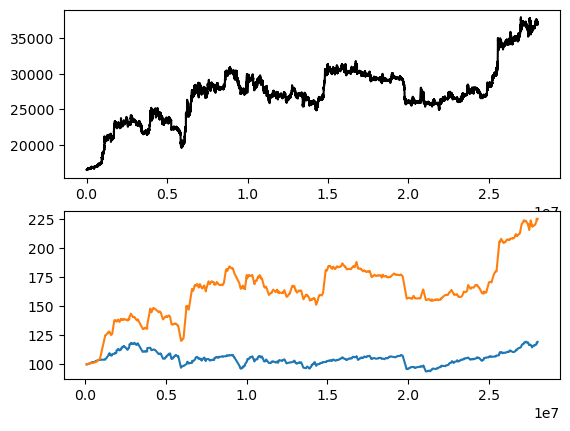

In [4]:
#
slow_window = 1*24*60
risk_factor = 0.8

t = spot_data[:,0]/1000
open_price = spot_data[:,1]
volume = spot_data[:,2]
n_points = len(t)

fast_mean = np.array([0,0])
slow_mean = np.array([0,0])

usd = 100
usd_balance = np.array([usd])

btc = 0
btc_hold = usd / open_price[slow_window]
purchase_price = 0

usd_balance_hold = np.array([usd])

n_trades = 0
t_trade = np.array(t[slow_window])

for current_index in range(slow_window, n_points):
	
	current_price = open_price[current_index]

	segment_start_idx = current_index - slow_window
	
	open_segment = open_price[segment_start_idx:current_index]
	open_mean = np.mean(open_segment)

	volume_segment = volume[segment_start_idx:current_index]
	volume_mean = np.mean(volume_segment)

	if usd:
		if current_price < open_mean and volume[current_index] > volume_mean:
		
			btc = usd / open_price[current_index]
			usd = 0
			print('Buy')

	if btc:
		current_price = open_price[current_index]

		# if purchase_price and current_price < purchase_price * risk_factor:
		# 	usd = btc * open_price[current_index]
		# 	btc = 0

		# 	t_trade = np.append(t_trade, t[current_index])
		# 	usd_balance = np.append(usd_balance, usd)
		# 	usd_balance_hold = np.append(usd_balance_hold, usd_hold)

		# 	print('STOP LOSS')

		if open_price[current_index] > open_mean and volume[current_index] < volume_mean:
		
			usd  = btc * open_price[current_index]
			usd_hold = btc_hold * open_price[current_index]
			btc = 0

			purchase_price = open_price[current_index]
			n_trades += 1

			t_trade = np.append(t_trade, t[current_index])
			usd_balance = np.append(usd_balance, usd)
			usd_balance_hold = np.append(usd_balance_hold, usd_hold)

			print('{}:Sell'.format(n_trades))

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t-t[0],open_price,color='black')
# ax1.plot(t[slow_window:]-t[0], fast_mean)
# ax1.plot(t[slow_window:]-t[0], slow_mean)

ax2.plot(t_trade-t[0], usd_balance)
ax2.plot(t_trade-t[0], usd_balance_hold)

plt.show()